In [1]:
import numpy as np
%pylab 
rcParams['figure.figsize'] = 12,8
from numba import jit
import random

import copy
import networkx as nx

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


### Random Network Generation

In [2]:
def getRandomConnectivity(N, pct_connected):
    #Directed mapping
    M = np.random.rand(N**2).reshape(N,N)
    for i in range(N):
        for j in range(N):
            if (i == j):
                M[i,j] = 0
            else:
                if (M[i,j] < pct_connected):
                    M[i,j] = 1 #i connects to j
                else:
                    M[i,j] = 0
    return M

### k-core functions 

In [3]:
def hasKcore(M, k):
    # we'll be destroying the array so make a copy to work with
    X = M.copy()
    while(True):
        cur_num_nodes = X.shape[0]
        s = np.sum(X, 0)
        nodes_to_delete = np.where(s < k)[0]
        if (len(nodes_to_delete) == cur_num_nodes):
            # nothing has at least k connections
            
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)
            
            return False
            break
        elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
            return True
            break
        else:
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)

            
# TODO get Kcore indices 

def largestKcore(M):
    # we can begin the search at the least connected node
    connectivity = np.sum(M,0)
    min_kcore = np.min(connectivity)
    max_kcore = np.max(connectivity)
    if max_kcore == 0:
        return 0
    k = min_kcore
    while (hasKcore(M,k)):
        k = k+1
        
    return k - 1
        
    
    
def largestkcore(M):
    # we can begin the search at the least connected node
    connectivity = np.sum(M,0)
    min_kcore = np.min(connectivity)
    max_kcore = np.max(connectivity)
    if max_kcore == 0:
        return 0
    k = min_kcore
    s=1
    while (s==1):
        
        X = M.copy()
        while(True):
            cur_num_nodes = X.shape[0]
            s = np.sum(X, 0)
            nodes_to_delete = np.where(s < k)[0]
            if (len(nodes_to_delete) == cur_num_nodes):
            # nothing has at least k connections
            
                X = np.delete(X, nodes_to_delete, axis=0)
                X = np.delete(X, nodes_to_delete, axis=1)
            
                s=0
                break
            elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
                s=1
                break
            else:
                X = np.delete(X, nodes_to_delete, axis=0)
                X = np.delete(X, nodes_to_delete, axis=1)
        k = k+1
        
    return k - 1

#TODO: Instead of deleting nodes, put 0's on all the connections for the rows and columns that are disconnected
    #Keeps number of all neurons the same so that neuron 3 doesnt become neuron 2 etc. 
    #Look for neurons not in Kcore which are firing and neurons that are in kcore and not firing. 
def kcoreitself(M, k):
    # we'll be destroying the array so make a copy to work with
    X = M.copy()
    
    while(True):
        cur_num_nodes = X.shape[0]
        s = np.sum(X, 0)
        nodes_to_delete = np.where(s < k)[0]
        if (len(nodes_to_delete) == cur_num_nodes):
            
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)
            # nothing has at least k connections
            return X
            break
        elif (len(nodes_to_delete) == 0):
            # They all have at least k connections, we've found a kcore
            return X
            break
        else:
            X = np.delete(X, nodes_to_delete, axis=0)
            X = np.delete(X, nodes_to_delete, axis=1)



#here we get the largest connected component of  the graph

def largestcomponent(l,N):
    n=np.random.randint(0,N)
    
    boundary=[n]
    b=1
    comp=[n]
    c=1
   
    while(b>0):
        a=boundary.pop()
        
        oldvertex=int(a)
        
        deg=l[oldvertex,0]
        degree=int(deg)
        #print(degree)
        for j in range(degree):
            newvertex=l[oldvertex,j+1]
            q=comp.count(newvertex)
            #print(newvertex)
            q=int(q)
            #print(q)
            if (q==0):
                comp.append(newvertex)
                boundary.append(newvertex)
                #print(newvertex)
                #print(boundary)
            
        b=len(boundary)
            
    #sizeofcomp=len(comp)
    return(comp)

def matrixOfEdges(M,N):
    N = int(N)
    E=np.zeros(N**2).reshape(N,N)  #prepare array with zeros
    k=np.sum(M,0) #array with degree of each vertex
    for i in range(N):
        a=int(k[i]) #degree of the current vertex
        E[i,0]=a  #we put it to the zero row of matrix of edges
    for i in range(N):
        a=int(k[i])
        q=1
        for j in range(N):
            if (M[j,i]==1):
                E[i,q]=j #all the next elements in current column are number of vertices current vertex is connected to
                q=q+1
    return(E)

def connectivityMap(l,N):
    N = int(N)
    M = np.zeros((N,N))
    
    for i in range(len(l)): 
        if l[i,0] == 0:
            M[i] = np.zeros(N)
        else:
            for j in range(1,int(l[i,0])+1):
                M[i,int(l[i,j])] = 1    
    return M.T
            

### Classifier

In [4]:
def cut(C): # Mihai ~ Removed unnecessary for loop 
    return C[int(0.9*len(C)):] #we take the second half of the time, when trajectory is close to SO, H,Q or chaos

def deriv(X):  #just a derivative
    N=len(X)
    if N == 0: 
        return []
    d=zeros(N-1)
    for i in range(N-1):
        d[i]=X[i+1]-X[i]
    return d

def muldev(X): #it is like a derivative but multiplication instead of difference
    N=len(X)
    md = zeros(N-1)
    for i in range(N-1):
        md[i]=X[i+1]*X[i]
    return md

def classifier(C1, timetolerance, Ctolerance):
    C=cut(C1) #we look at the second half when it closer to the cycle or whatever it is
    N=len(C)
    countermax=0
    countermin=0
    Cprime=deriv(C)
    Cmd=muldev(Cprime)
    Cpp = deriv(Cprime)
    for i in range(N-2):
        if (Cmd[i]<0): #if sign of derivative changes it means that it max or min
            if (Cpp[i]>0): #if second derivative > 0 it is min
                countermin=countermin+1
            else:
                countermax=countermax+1 # else it is max
    
    max_C = max(C[int(.75*N):N])
    min_C = min(C[int(.75*N):N])
    
    #print(max_C, ",", min_C)
    
    if ((max_C - min_C) < Ctolerance):
        return 2
    
    if ((countermin == 0) and (countermax == 0)):
        return 2
    
    maximums=np.zeros(countermax)
    minimums=np.zeros(countermin)
    maxtimes=np.zeros(countermax)
    mintimes=np.zeros(countermin)
    qmax=0 #counter of max
    qmin=0 #counter of min
    for i in range(N-2):
        if (Cmd[i]<0):
            if (Cpp[i]>0):
                mintimes[qmin]=i #the time when min occurs
                minimums[qmin]=C[i] #the value
                qmin=qmin+1 
            else:
                maxtimes[qmax]=i #the same story for max
                maximums[qmax]=C[i]
                qmax=qmax+1
    
    ### Mihai ~ ADDED TEMPORARY MAGIC NUMBERS TO FIX OFF BY 1 ### 
    min_dim = min(len(maxtimes),len(mintimes))
    maxtimes = maxtimes[:min_dim]
    mintimes = mintimes[:min_dim]
    
    minperiods=deriv(mintimes)
    maxperiods=deriv(maxtimes)
    #print(minperiods)
    #print(maxperiods)

    if(len(maxtimes)+len(mintimes)-2 < 2):  #if the period is too long #Mihai ~ Changed to .any(), but formulation is ambiguous
        print('Increase observation time N*dt')
        return(-1) #-1 is error 
    
    
    checker=1    #we will check conditions for this stuff to be cycle, not chaos. If at lest one of them fails, we put checker to 0
    avper=(sum(minperiods)+sum(maxperiods))*1.0/(countermin+countermax-2) #average period
    #print(avper)
    #print(minimums)
    #print(maximums)
    avmin=sum(minimums)*1.0/countermin #average value of minimum
    avmax=sum(maximums)*1.0/countermax #average value of maximum
    if (avmax-avmin<Ctolerance):
        return(2) #if the difference between min and max smaller than tolerance it is fixed point
    #for i in range(countermin-1):
    for i in range(countermin-2):
        if (abs(minperiods[i]-avper)>timetolerance): #if the deviation from the average larger than the tolerance
            checker=0 #than it is not SO
    #for i in range(countermax-1):
    for i in range(countermax-2):
        if (abs(maxperiods[i]-avper)>timetolerance):
            checker=0
    for i in range(countermin):
        if (abs(minimums[i]-avmin)>Ctolerance):
            checker=0
    for i in range(countermax):
        if (abs(maximums[i]-avmax)>Ctolerance):
            checker=0
    return(checker) #1 is SO, 0 is chaos. 2 is fixed point. -1 is error. 

In [58]:
#TODO: Sloppy, clean up. 
@jit(nopython=True)
def simDynamics(M, l, params):  #params is a vector of parameters
    N=int(params[0])
    n=int(params[1])
    dt=params[2]
    tauv=params[3]
    tauc=params[4]
    Vstar=params[5]
    Cstar=params[6]
    delV=params[7]
    delC=params[8]
    r=params[9]
    V0=params[10]
    C0=params[11]
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    P=zeros(n)  # function P(V), sigmoid
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    g_v=params[12]
    g_c=params[13]
    r_0=params[14]

    firing_neurons_count = zeros(N*n).reshape(N,n) #Keep dimensions of C and V

    for i in range(n):
        
        V[0,i] = V0 #initial conditions
        C[0,i] = C0 

        #V[0,i] = np.random.uniform(Vstar-1,Vstar+1)
        #C[0,i] = np.random.uniform(Cstar-1,Cstar+1)
        
        if V[0,i] < 10: 
            firing_neurons_count[0,i] = 1 #Firing count based on I.C's 
        elif V[0,i] < 25:
            firing_neurons_count[0,i] = 2
        elif V[0,i] < 40:
            firing_neurons_count[0,i] = 3
        elif V[0,i] >= 40:
            firing_neurons_count[0,i] = 4

        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1):
        for j in range(n):
            P[j] = r/(1+exp((Vstar-V[i,j])/g_v)) + r_0 #Added r_0
            #print(P[j]) #Debug statement to see range of P[j]
        for j in range(n):
            a=int(l[j,0])
            for k in range(a):
                b=int(l[j,k])
                sump[j]=sump[j]+P[b]  #if neuron connected to j-th neuron it participates in sum
        for j in range(n):
            V[i+1,j]=(-V[i,j]/tauv + delV*sump[j]*(1/(1+exp((C[i,j]-Cstar)/g_c))) )*dt + V[i,j]
            C[i+1,j]=(-C[i,j]/tauc + delC*sump[j])*dt + C[i,j]

            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
        for j in range(n):
            sump[j]=0
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n

        #plot([avC[i],avC[i+1]],[avV[i],avV[i+1]])    
    return(avC,avV,C,V)#,firing_neurons_count) #Now also return count of firing neurons

@jit(nopython=True)
def simDynamics2(M, l, params):  #params is a vector of parameters
    N=int(params[0])
    n=int(params[1])
    dt=params[2]
    tauv=params[3]
    tauc=params[4]
    Vstar=params[5]
    Cstar=params[6]
    delV=params[7]
    delC=params[8]
    r_1=params[9]
    V0=params[10]
    C0=params[11]
    delVmin=params[12]
    r_0=params[13]
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    #P=zeros(n)  # function P(V), sigmoid
    P = zeros(N*n).reshape(N,n)
    deltaV=zeros(n)
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    firing_neurons_count = zeros(N*n).reshape(N,n) #Individually count how may neurons are actually firing in this model at a given step N.
    
    for i in range(n):
        V[0,i]= np.random.uniform(0, 2*Vstar)#V0 #initial conditions
        C[0,i]= np.random.uniform(Cstar - 0.5, Cstar + 0.5)#C0 
        if V[0,i] > Vstar: #keep track of and return how many neurons in the network are actually firing  
            firing_neurons_count[0,i] = 1
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1):
        for j in range(n):
            if (V[i,j]>Vstar): #V[i,j] stores voltage of each neuron instead of returning the average voltage 
                P[i,j]=r_1+r_0
            else:
                P[i,j]=r_0
            if (C[i,j]<Cstar):
                deltaV[j]=delV #change from 1.2 
            else:
                deltaV[j]=0#delVmin #changed from .4
        for j in range(n):
            a=int(l[j,0]) #a should give number of firing neighbors 
            for k in range(a):
                #b=int(l[j,k])
                b = int(l[j,k+1])
                sump[j]=sump[j]+P[i,b]  #if neuron connected to j-th neuron it participates in sum
        for j in range(n):
            V[i+1,j]=(-V[i,j]/tauv + deltaV[j]*sump[j])*dt + V[i,j]
            if V[i+1,j] > Vstar: 
                firing_neurons_count[i+1,j] = 1 #used to return count of firing neurons later
            #if ((firing_neurons_count[i,j] == 1) and (firing_neurons_count[i+1,j] == 0)):
            #    print(sump[j])
            #C[i+1,j]=(-C[i,j]/tauc + delC*(r_1+r_0)*sump[j])*dt + C[i,j]
            C[i+1,j]=(-C[i,j]/tauc + delC*sump[j])*dt + C[i,j]
            #print(sump[j])
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
        for j in range(n):
            sump[j]=0
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n
        
        #plot([avC[i],avC[i+1]],[avV[i],avV[i+1]])    
    return(avC,avV, firing_neurons_count, P, V, C)

@jit(nopython=True)
def mean_field_dynamics(params):
    N = int(params[0])
    n = int(params[1]) 
    dt = params[2]
    tauv = params[3]
    tauc = params[4] 
    Vstar = params[5] 
    Cstar = params[6]
    delV = params[7]
    delC = params[8]
    r_1 = params[9]
    r_0 = params[10]
    V_0 = params[11]
    C_0 = params[12]
    
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    
    firing_neurons_count = zeros(N*n).reshape(N,n) #Individually count how may neurons are actually firing in this model at a given step N.
    
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    
    for i in range(n):
        V[0,i]=V_0 #initial conditions
        C[0,i]=C_0
        if V[0,i] > Vstar: #keep track of and return how many neurons in the network are actually firing  
            firing_neurons_count[0,i] = 1
        avV[0]=n*V_0  #we will divide to n later
        avC[0]=n*C_0
    
    for i in range(N - 1): 
        for j in range(n):
            if V[i,j] > Vstar: 
                r = r_1
            else:
                r = 0

            if C[i,j] < Cstar: 
                dV = delV 
            else: 
                dV = 0

            V[i+1,j] = (-V[i,j]/tauv + (n-1)*dV*(r + r_0)) * dt + V[i,j]
            if V[i+1,j] > Vstar: 
                firing_neurons_count[i+1,j] = 1
            C[i+1,j] = (-C[i,j]/tauc + (n-1)*delC*(r + r_0)) * dt + C[i,j]
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
            
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n    
    
    return avC, avV, firing_neurons_count 

@jit(nopython=True)
def mean_field_dynamics2(params):
    N=int(params[0])
    n=int(params[1])
    dt=params[2]
    tauv=params[3]
    tauc=params[4]
    Vstar=params[5]
    Cstar=params[6]
    delV=params[7]
    delC=params[8]
    r=params[9]
    V0=params[10]
    C0=params[11]
    Va=zeros(N)  #now we have potencial and calcium concentration for each neuron
    Ca=zeros(N)
    Vi=zeros(N)
    Ci=zeros(N)
    P=zeros(n)  # function P(V), sigmoid
    sump=zeros(n)  #sum of P over the vertices
    avVa=zeros(N) #average potencial
    avCa=zeros(N)  #average calcium
    avVi=zeros(N) 
    avCi=zeros(N)  
    g_v=params[12]
    g_c=params[13]
    r_0=params[14]
    
    n_firing = 32
    m_not_firing = n-32
    
    for i in range(n):
        Va[0]=Vstar+1 #initial conditions
        Ca[0]=Cstar-1
        Vi[0]=Vstar-1 #initial conditions
        Ci[0]=Cstar+1

    for i in range(N - 1): 
        
        #Change to Va
        #V[i+1,j] = (-V[i,j]/tauv + (n-1)*dV*(r + r_0)) * dt + V[i,j]
        Va[i+1] = (-Va[i]/tauv + (1/(1+exp((Ca[i]-Cstar)/g_c))) * 
                     ((n_firing-1)*(r/(1+exp((Vstar-Va[i])/g_v)) + r_0) + 
                    m_not_firing*(r/(1+exp((Vstar-Vi[i])/g_v)) + r_0))) * dt + Va[i] 
        Ca[i+1] = (-Ca[i]/tauc + (delC * ((n_firing-1)*(r/(1+exp((Vstar-Va[i])/g_v)) + r_0) + 
                    m_not_firing*(r/(1+exp((Vstar-Vi[i])/g_v)) + r_0)))) * dt + Ca[i]

        Vi[i+1] = (-Vi[i]/tauv + (1/(1+exp((Ci[i]-Cstar)/g_c))) * 
                     ((n_firing)*(r/(1+exp((Vstar-Va[i])/g_v)) + r_0) + 
                    (m_not_firing - 1)*(r/(1+exp((Vstar-Vi[i])/g_v)) + r_0))) * dt + Va[i] 
        Ci[i+1] = (-Ci[i]/tauc + (delC * ((n_firing)*(r/(1+exp((Vstar-Va[i])/g_v)) + r_0) + 
                    (m_not_firing - 1)*(r/(1+exp((Vstar-Vi[i])/g_v)) + r_0)))) * dt + Ca[i]

    return Va, Ca, Vi, Ci

#Calcium concentration follows step function
@jit(nopython=True)
def simDynamics3(M, l, params):  #params is a vector of parameters
    N=int(params[0])
    n=int(params[1])
    dt=params[2]
    tauv=params[3]
    tauc=params[4]
    Vstar=params[5]
    Cstar=params[6]
    delV=params[7]
    delC=params[8]
    r=params[9]
    V0=params[10]
    C0=params[11]
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    P=zeros(n)  # function P(V), sigmoid
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    g_v = params[12]
    g_c = params[13]
    r_0 = params[14]
    
    
    deltaV=zeros(n)

    firing_neurons_count = zeros(N*n).reshape(N,n) #Keep dimensions of C and V

    for i in range(n):
        
        V[0,i] = V0 #initial conditions
        C[0,i] = C0 

        #V[0,i] = np.random.uniform(Vstar-1,Vstar+1)
        #C[0,i] = np.random.uniform(Cstar-1,Cstar+1)
        
        if V[0,i] < 10: 
            firing_neurons_count[0,i] = 1 #Firing count based on I.C's 
        elif V[0,i] < 25:
            firing_neurons_count[0,i] = 2
        elif V[0,i] < 40:
            firing_neurons_count[0,i] = 3
        elif V[0,i] >= 40:
            firing_neurons_count[0,i] = 4

        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1):
        for j in range(n):
            P[j] = r/(1+exp((Vstar-V[i,j])/g_v)) + r_0 #Added r_0
            #print(P[j]) #Debug statement to see range of P[j]
        for j in range(n):
            a=int(l[j,0])
            for k in range(a):
                b=int(l[j,k])
                sump[j]=sump[j]+P[b]  #if neuron connected to j-th neuron it participates in sum
        for j in range(n):
            if (C[i,j]<Cstar):
                deltaV[j]=delV #change from 1.2 
            else:
                deltaV[j]=0#delVmin #changed from .4
            V[i+1,j]=(-V[i,j]/tauv + deltaV[j]*sump[j])*dt + V[i,j]
            C[i+1,j]=(-C[i,j]/tauc + delC*sump[j])*dt + C[i,j]

            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
        for j in range(n):
            sump[j]=0
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n

        #plot([avC[i],avC[i+1]],[avV[i],avV[i+1]])    
    return(avC,avV,C,V)#,firing_neurons_count) #Now also return count of firing neurons

#Firing rate follows step function
@jit(nopython=True)
def simDynamics4(M, l, params):  #params is a vector of parameters
    N=int(params[0])
    n=int(params[1])
    dt=params[2]
    tauv=params[3]
    tauc=params[4]
    Vstar=params[5]
    Cstar=params[6]
    delV=params[7]
    delC=params[8]
    r=params[9]
    V0=params[10]
    C0=params[11]
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    P=zeros(n)  # function P(V), sigmoid
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    g_v = params[12]
    g_c = params[13]
    r_0 = params[14]
    
    
    deltaV=zeros(n)

    firing_neurons_count = zeros(N*n).reshape(N,n) #Keep dimensions of C and V

    for i in range(n):
        
        V[0,i] = V0 #initial conditions
        C[0,i] = C0 

        #V[0,i] = np.random.uniform(Vstar-1,Vstar+1)
        #C[0,i] = np.random.uniform(Cstar-1,Cstar+1)
        
        if V[0,i] < 10: 
            firing_neurons_count[0,i] = 1 #Firing count based on I.C's 
        elif V[0,i] < 25:
            firing_neurons_count[0,i] = 2
        elif V[0,i] < 40:
            firing_neurons_count[0,i] = 3
        elif V[0,i] >= 40:
            firing_neurons_count[0,i] = 4

        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1):
        for j in range(n):
            P[j] = r/(1+exp((Vstar-V[i,j])/g_v)) + r_0 #Added r_0
            #print(P[j]) #Debug statement to see range of P[j]
        for j in range(n):
            a=int(l[j,0])
            for k in range(a):
                b=int(l[j,k])
                sump[j]=sump[j]+P[b]  #if neuron connected to j-th neuron it participates in sum
        for j in range(n):
            if (C[i,j]<Cstar):
                deltaV[j]=delV #change from 1.2 
            else:
                deltaV[j]=0#delVmin #changed from .4
            V[i+1,j]=(-V[i,j]/tauv + deltaV[j]*sump[j])*dt + V[i,j]
            C[i+1,j]=(-C[i,j]/tauc + delC*sump[j])*dt + C[i,j]

            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
        for j in range(n):
            sump[j]=0
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n

        #plot([avC[i],avC[i+1]],[avV[i],avV[i+1]])    
    return(avC,avV,C,V)#,firing_neurons_count) #Now also return count of firing neurons

class Network: 
    def __init__(self, M, l, params):
        self.M_init = M
        self.l_init = l 
        self.M = M
        self.l = l
        self.params = params
        self.N = int(params[0])
        self.n_init = int(params[1])
        self.n = int(params[1])
        self.dt = params[2]
        self.tauv = params[3]
        self.tauc = params[4]
        self.Vstar = params[5]
        self.Cstar = params[6]
        self.delV = params[7]
        self.delC = params[8]
        self.r = params[9]
        self.V0 = params[10]
        self.C0 = params[11]
        self.g_v = params[12]
        self.g_c = params[13]
        self.r_0 = params[14]
        self.n_edges = np.sum(self.l[:,0])
        self.kill_order = []
        
    def kill_neuron(self):
        x = 1
        self.n -= 1
        self.params[1] = self.n
        self.M = np.delete(self.M,x,axis=0)
        self.M = np.delete(self.M,x,axis=1)
        #self.M[x] = np.zeros(self.n_init)
        #self.M[:,x] = np.zeros(self.n_init)
        self.l = matrixOfEdges(self.M, self.n)

    def killEdge(self):
        l_copy = copy.deepcopy(self.l)
        
        non_zero_rows = []
        
        for i in range(self.n):
            if l_copy[i,0] != 0:
                non_zero_rows.append(i)
            # Experimental removal of neurons as all incoming edges are killed 
            #else:
            #    self.n -= 1
            
        
        #randomly pick a row that has some connections
        if len(non_zero_rows) == 0:
            return False
        
        row_idx = random.randint(0,len(non_zero_rows) - 1)
        row = non_zero_rows[row_idx]
        
        if l_copy[row,0] == 0:
            self.l = l_copy
            return False
        
        else: 
            #randomly pick edge
            edge_idx = random.randint(1,l_copy[row,0])
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]
            
            #remove entry and roll array 
            row_reinsert[edge_idx] = 0
            
            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert
            
            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
            
            return True
        
    def killEdge2(self, n):
        for i in range(n): 
            l_copy = copy.deepcopy(self.l)
        
            non_zero_rows = []

            for j in range(self.n):
                if l_copy[j,0] != 0:
                    non_zero_rows.append(j)
                    
            row = non_zero_rows[self.kill_order[i][0]]
            
        
            #randomly pick edge
            edge_idx = self.kill_order[i][1]
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]

            #remove entry and roll array 
            row_reinsert[edge_idx] = 0

            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert

            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
        
    def init_kill_order(self):
        while True:
            l_copy = copy.deepcopy(self.l)

            non_zero_rows = []

            for i in range(self.n):
                if l_copy[i,0] != 0:
                    non_zero_rows.append(i)
                # Experimental removal of neurons as all incoming edges are killed 
                #else:
                #    self.n -= 1


            #randomly pick a row that has some connections
            if len(non_zero_rows) == 0:
                #reset initial values 
                self.M = self.M_init
                self.l = self.l_init
                self.n_edges = np.sum(self.l_init[:,0])
                break

            row_idx = random.randint(0,len(non_zero_rows) - 1)
            row = non_zero_rows[row_idx]

            #randomly pick edge
            edge_idx = random.randint(1,l_copy[row,0])
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]

            #remove entry and roll array 
            row_reinsert[edge_idx] = 0

            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert

            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
            
            self.kill_order.append((row_idx, edge_idx))
        
    def simdyn(self, M, l, params):
        return simDynamics(self.M, self.l, self.params)
    
class StepNetwork:
    def __init__(self, M, l, params):
        self.M_init = M
        self.M = M
        self.l_init = l
        self.l = l
        self.params = params 
        self.n = int(params[1])
        
        self.n_edges = np.sum(self.l[:,0])
        self.kill_order = []
        
    def killEdge(self):
        l_copy = copy.deepcopy(self.l)
        
        non_zero_rows = []
        
        for i in range(self.n):
            if l_copy[i,0] != 0:
                non_zero_rows.append(i)
            # Experimental removal of neurons as all incoming edges are killed 
            #else:
            #    self.n -= 1
            
        
        #randomly pick a row that has some connections
        if len(non_zero_rows) == 0:
            return False
        
        row_idx = random.randint(0,len(non_zero_rows) - 1)
        row = non_zero_rows[row_idx]
        
        if l_copy[row,0] == 0:
            self.l = l_copy
            return False
        
        else: 
            #randomly pick edge
            edge_idx = random.randint(1,l_copy[row,0])
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]
            
            #remove entry and roll array 
            row_reinsert[edge_idx] = 0
            
            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert
            
            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
            
            return True
        
    def killEdge2(self, n):
        for i in range(n): 
            l_copy = copy.deepcopy(self.l)
        
            non_zero_rows = []

            for j in range(self.n):
                if l_copy[j,0] != 0:
                    non_zero_rows.append(j)
                    
            row = non_zero_rows[self.kill_order[i][0]]
            
        
            #randomly pick edge
            edge_idx = self.kill_order[i][1]
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]

            #remove entry and roll array 
            row_reinsert[edge_idx] = 0

            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert

            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
        
    def init_kill_order(self):
        while True:
            l_copy = copy.deepcopy(self.l)

            non_zero_rows = []

            for i in range(self.n):
                if l_copy[i,0] != 0:
                    non_zero_rows.append(i)
                # Experimental removal of neurons as all incoming edges are killed 
                #else:
                #    self.n -= 1


            #randomly pick a row that has some connections
            if len(non_zero_rows) == 0:
                #reset initial values 
                self.M = self.M_init
                self.l = self.l_init
                self.n_edges = np.sum(self.l_init[:,0])
                break

            row_idx = random.randint(0,len(non_zero_rows) - 1)
            row = non_zero_rows[row_idx]

            #randomly pick edge
            edge_idx = random.randint(1,l_copy[row,0])
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]

            #remove entry and roll array 
            row_reinsert[edge_idx] = 0

            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert

            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
            
            self.kill_order.append((row_idx, edge_idx))
        
    #Return JIT'd dynamics simulation for step function 
    def simdyn(self, M, l, params): 
        #return simDynamics2(self.M, self.l, self.params)
        return simDynamics3(self.M, self.l, self.params)
    
class MeanFieldStepNetwork:
    def __init__(self, M, l, params):
        self.M_init = M
        self.M = M
        self.l_init = l
        self.l = l
        self.params = params 
        self.n = int(params[1])
        
        self.n_edges = np.sum(self.l[:,0])
        self.kill_order = []
        
    def killEdge(self):
        l_copy = copy.deepcopy(self.l)
        
        non_zero_rows = []
        
        for i in range(self.n):
            if l_copy[i,0] != 0:
                non_zero_rows.append(i)
            # Experimental removal of neurons as all incoming edges are killed 
            #else:
            #    self.n -= 1
            
        
        #randomly pick a row that has some connections
        if len(non_zero_rows) == 0:
            return False
        
        row_idx = random.randint(0,len(non_zero_rows) - 1)
        row = non_zero_rows[row_idx]
        
        if l_copy[row,0] == 0:
            self.l = l_copy
            return False
        
        else: 
            #randomly pick edge
            edge_idx = random.randint(1,l_copy[row,0])
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]
            
            #remove entry and roll array 
            row_reinsert[edge_idx] = 0
            
            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert
            
            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
            
            return True
        
    def killEdge2(self, n):
        for i in range(n): 
            l_copy = copy.deepcopy(self.l)
        
            non_zero_rows = []

            for j in range(self.n):
                if l_copy[j,0] != 0:
                    non_zero_rows.append(j)
                    
            row = non_zero_rows[self.kill_order[i][0]]
            
        
            #randomly pick edge
            edge_idx = self.kill_order[i][1]
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]

            #remove entry and roll array 
            row_reinsert[edge_idx] = 0

            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert

            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
        
    def init_kill_order(self):
        while True:
            l_copy = copy.deepcopy(self.l)

            non_zero_rows = []

            for i in range(self.n):
                if l_copy[i,0] != 0:
                    non_zero_rows.append(i)
                # Experimental removal of neurons as all incoming edges are killed 
                #else:
                #    self.n -= 1


            #randomly pick a row that has some connections
            if len(non_zero_rows) == 0:
                #reset initial values 
                self.M = self.M_init
                self.l = self.l_init
                self.n_edges = np.sum(self.l_init[:,0])
                break

            row_idx = random.randint(0,len(non_zero_rows) - 1)
            row = non_zero_rows[row_idx]

            #randomly pick edge
            edge_idx = random.randint(1,l_copy[row,0])
            row_reinsert = l_copy[row]#np.zeros(self.n)
            row_reinsert[0] = l_copy[row,0] - 1
            row_reinsert[1:edge_idx] = l_copy[row,1:edge_idx]

            #remove entry and roll array 
            row_reinsert[edge_idx] = 0

            rolled = np.roll(row_reinsert[edge_idx:],-1)
            row_reinsert[edge_idx:] = rolled
            l_copy[row] = row_reinsert

            self.l = l_copy
            self.M = connectivityMap(self.l, self.n)
            self.n_edges -= 1
            
            self.kill_order.append((row_idx, edge_idx))
        
    #Return JIT'd dynamics simulation for step function 
    def simdyn(self, params): 
        return mean_field_dynamics2(self.params)
        #return simDynamics3(self.M, self.l, self.params)
     

### Calcium with step function

In [55]:
n = 100
p = 1. #Probability of Connection 
M = getRandomConnectivity(n,p)
l = matrixOfEdges(M,n)

In [61]:
N = 10000 #15000
dt = 0.00001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 5. #1.2
delVmin = delV/3 #delV/3
delC= 0.01 #0.01
r_1= 70#*99/4#Max Firing rate is r_1 + r_0 70
r_0 = 5#*99/4 #Min firing rate 5
g_v = 5
g_c = 0.1

params=zeros(15)
params[0]=N
params[1]=n #instead of actual n, cull neurons til desired value
params[2]=dt
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r_1
params[10]=V0
params[11]=C0
params[12]=g_v #connenctivity rate from above.
params[13]=g_c 
params[14]=r_0

#network = StepNetwork(M,l,params)
network = Network(M,l,params)

C,V,c_arr,v_arr = network.simdyn(network.M, network.l, network.params)

Text(0.5, 1.0, '1')

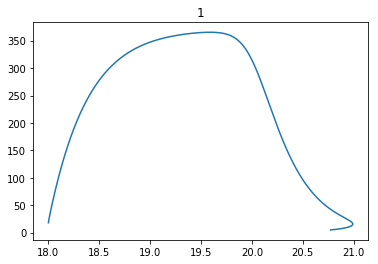

In [62]:
plot(C,V)
title(classify(V,params))

In [19]:
N = 10000 #Number of Steps 
dt = 0.001
n = 10 #100

T = zeros(N)

V_0, C_0 = 18, 18

tauv = 0.01 #0.01
tauc = 0.5 #0.5

Vstar = 15#15
Cstar = 20#20



delV = 5. #1.
delC = 0.01#0.015, 0.01
r_1 = 770 #3000
r_0 = 55 #5

conditions = tauc*delC*r_1 > Cstar and tauc*delC*r_0 < Cstar and delV*tauv*r_0 > Vstar

params = zeros(13)
params[0] = N
params[1] = n
params[2] = dt 
params[3] = tauv 
params[4] = tauc 
params[5] = Vstar
params[6] = Cstar 
params[7] = delV 
params[8] = delC 
params[9] = r_1 
params[10] = r_0 
params[11] = V_0
params[12] = C_0

network = MeanFieldStepNetwork(M,l,params)

Cm,Vm,c = network.simdyn(network.params)

plt.plot(Cm,Vm,lw=4)
print("Classification:", classify(Vm,params))
print("Conditions for SO phase met:", conditions)

#plt.title("High Voltage Fixed Point")
plt.xlabel("C",fontsize=30)
plt.ylabel("V",fontsize=30)
plt.tick_params(axis='both', labelsize=25)

ValueError: too many values to unpack (expected 3)

In [12]:
n = 100
p = 1. #Probability of Connection 
M = getRandomConnectivity(n,p)
l = matrixOfEdges(M,n)

N = 200000 #15000
dt = 0.001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv = 0.01 
tauc = 0.5
Vstar = 15
Cstar = 20 
V0 = 10 #20
C0 = 24 #24

delV = 5. #12
delC = 0.015
r = 70
r_0 = 5

g = 5.
g_v = g #.95
g_c = 0.0001 #.95

params = zeros(15)
params[0] = N
params[1] = n
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M,l,params)

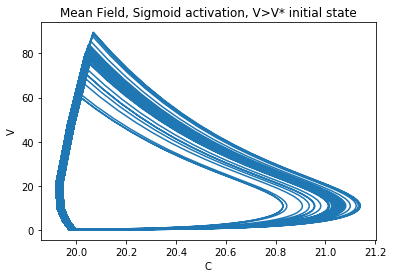

In [13]:
C,V,c_arr,v_arr = network.simdyn(M,l,params)
title("Mean Field, Sigmoid activation, V>V* initial state")
xlabel("C")
ylabel("V")
plot(C[N//2:],V[N//2:])
#savefig("meeting_figs/mean_field_sig_v_init.png")

In [534]:
network.n_edges

9900.0

In [535]:
for i in range(1000):
    network.killEdge()

In [538]:
title(classifier(V,1/dt,0.1))
plot(C,V)

In [6]:
##########DEPRECATED##########
def classify(V, params):
    #Set up some globals 
    
    N = int(params[0])
    n = int(params[1])
    
    #Network uniformly connected but vectorized lets us scale later 
    #for i in range (N/2, N):
    #max_V = max(V[int(N/2):N])
    #min_V = min(V[int(N/2):N])
    max_V = max(V[int(.9*N):N])
    min_V = min(V[int(.9*N):N])
   
            
    V_delta = max_V - min_V
    #print(V_delta)
    
    if V_delta < 0.001: #changed from 1
        if V[N-1] < 15:
            #params[12] = 2
            return 2
        else:
            #params[12] = 3
            return 3
    else:
        #params[12] = 1
        return 1
    
#print(classify(V,network.params)) #1: SO, 2,3: F
#print(classifier(V,1/dt,0.1)) # 0: Chaos, 1: SO, 2:F

In [336]:
print(network.l, '\n')
print(network.killEdge(), '\n')
print(network.l)


[[3. 1. 4. 9. 0. 0. 0. 0. 0. 0.]
 [3. 0. 5. 6. 0. 0. 0. 0. 0. 0.]
 [2. 3. 4. 0. 0. 0. 0. 0. 0. 0.]
 [6. 0. 1. 4. 6. 7. 9. 0. 0. 0.]
 [6. 0. 3. 5. 6. 7. 8. 0. 0. 0.]
 [5. 0. 1. 3. 6. 7. 0. 0. 0. 0.]
 [5. 3. 5. 7. 8. 9. 0. 0. 0. 0.]
 [3. 0. 2. 9. 0. 0. 0. 0. 0. 0.]
 [4. 1. 3. 5. 7. 0. 0. 0. 0. 0.]
 [4. 4. 5. 7. 8. 0. 0. 0. 0. 0.]] 

True 

[[3. 1. 4. 9. 0. 0. 0. 0. 0. 0.]
 [3. 0. 5. 6. 0. 0. 0. 0. 0. 0.]
 [2. 3. 4. 0. 0. 0. 0. 0. 0. 0.]
 [6. 0. 1. 4. 6. 7. 9. 0. 0. 0.]
 [6. 0. 3. 5. 6. 7. 8. 0. 0. 0.]
 [5. 0. 1. 3. 6. 7. 0. 0. 0. 0.]
 [5. 3. 5. 7. 8. 9. 0. 0. 0. 0.]
 [2. 0. 9. 0. 0. 0. 0. 0. 0. 0.]
 [4. 1. 3. 5. 7. 0. 0. 0. 0. 0.]
 [4. 4. 5. 7. 8. 0. 0. 0. 0. 0.]]


In [695]:
n = 75
p = 1. #Probability of Connection 
M = getRandomConnectivity(n,p)
l = matrixOfEdges(M,n)

N = 10000 #15000
dt = 0.0001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv = 0.01 
tauc = 0.5
Vstar = 15
Cstar = 20 
V0 = 10 #20
C0 = 24 #24

delV = 5. #12
delC = 0.015
r = 70
r_0 = 5

g = 0.1
g_v = g #.95
g_c = g #.95

params = zeros(15)
params[0] = N
params[1] = n
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M,l,params)
network.init_kill_order()

g_max = 5.0
dg = 0.05
edge_min = 100
edge_step = 10

phasen = []
phaseg = []

while True: 
    C,V = network.simdyn(network.M,network.l,network.params)
    #classification1 = classifier(V,1/dt,0.1)
    classification1 = classify(V,network.params)
    while True: 
        for i in range(edge_step):
            network.killEdge()
        if network.n_edges <= edge_min:
            network.params[12] += dg 
            network.params[13] += dg 
            network.M = network.M_init
            network.l = network.l_init
            network.n_edges = np.sum(network.l_init[:,0])
            break
        C,V = network.simdyn(network.M,network.l,network.params)
        #classification2 = classifier(V,1/dt,0.1)
        classification2 = classify(V,network.params)
        if classification2 != classification1: 
            print("Transition at edges = {}, g = {}, from {} to {}".format(network.n_edges,network.params[12],
                                                                          classification1,classification2))
            phasen.append(network.n_edges)
            phaseg.append(network.params[12])

            network.params[12] += dg 
            network.params[13] += dg 
            network.M = network.M_init
            network.l = network.l_init 
            network.n_edges = np.sum(network.l_init[:,0])
            break
            
    if network.params[12] >= g_max:
        break

Transition at edges = 3640.0, g = 0.1, from 1 to 2
Transition at edges = 3470.0, g = 0.15000000000000002, from 1 to 2
Transition at edges = 3360.0, g = 0.2, from 1 to 2
Transition at edges = 3370.0, g = 0.25, from 1 to 2
Transition at edges = 3320.0, g = 0.3, from 1 to 2
Transition at edges = 3040.0, g = 0.35, from 1 to 2
Transition at edges = 3270.0, g = 0.39999999999999997, from 1 to 2
Transition at edges = 3010.0, g = 0.44999999999999996, from 1 to 2
Transition at edges = 2810.0, g = 0.49999999999999994, from 1 to 2
Transition at edges = 2950.0, g = 0.5499999999999999, from 1 to 2
Transition at edges = 2880.0, g = 0.6, from 1 to 2
Transition at edges = 2810.0, g = 0.65, from 1 to 2
Transition at edges = 2640.0, g = 0.7000000000000001, from 1 to 2
Transition at edges = 2730.0, g = 0.7500000000000001, from 1 to 2
Transition at edges = 2710.0, g = 0.8000000000000002, from 1 to 2
Transition at edges = 2640.0, g = 0.8500000000000002, from 1 to 2
Transition at edges = 2440.0, g = 0.900000

In [698]:
xlabel("g")
ylabel("edges")
plot(phaseg,phasen)
savefig("prelim.png")

In [687]:
n = 50
p = 1. #Probability of Connection 
M = getRandomConnectivity(n,p)
l = matrixOfEdges(M,n)

N = 10000 #15000
dt = 0.0001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv = 0.01 
tauc = 0.5
Vstar = 15
Cstar = 20 
V0 = 10 #20
C0 = 24 #24

delV = 5. #12
delC = 0.015
r = 70
r_0 = 5

g = 0.1
g_v = g #.95
g_c = g #.95

params = zeros(15)
params[0] = N
params[1] = n
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M,l,params)
network.init_kill_order()

g_max = 5.0
dg = 0.1
edge_min = network.n_edges//4
edge_step = 20

phasen = []
phaseg = []

while True: 
    C,V = network.simdyn(network.M,network.l,network.params)
    #classification1 = classifier(V,1/dt,0.1)
    classification1 = classify(V,network.params)
    while True: 
        step_counter = 1
        if step_counter * edge_step >= network.n_edges:
            network.params[12] += dg 
            network.params[13] += dg 
            network.M = network.M_init
            network.l = network.l_init
            network.n_edges = np.sum(network.l_init[:,0])
            break
        else:
            network.killEdge2(step_counter)
        #for i in range(edge_step):
        #    network.killEdge()
        if network.n_edges <= edge_min:
            network.params[12] += dg 
            network.params[13] += dg 
            network.M = network.M_init
            network.l = network.l_init
            network.n_edges = np.sum(network.l_init[:,0])
            break
        C,V = network.simdyn(network.M,network.l,network.params)
        #classification2 = classifier(V,1/dt,0.1)
        classification2 = classify(V,network.params)
        if classification2 != classification1: 
            print("Transition at edges = {}, g = {}, from {} to {}".format(network.n_edges,network.params[12],
                                                                          classification1,classification2))
            phasen.append(network.n_edges)
            phaseg.append(network.params[12])

            network.params[12] += dg 
            network.params[13] += dg 
            network.M = network.M_init
            network.l = network.l_init 
            network.n_edges = np.sum(network.l_init[:,0])
            break
        step_counter += 1
            
    if network.params[12] >= g_max:
        break

IndexError: list index out of range

In [582]:
C,V = network.simdyn(network.M_init,network.l_init,network.params)

In [583]:
title(classifier(V,1/dt,0.1))
plot(C,V)

In [589]:
network.params[12] = 5.0
network.params[13] = 5.0

C,V = network.simdyn(network.M_init,network.l_init,network.params)

In [592]:
for i in range(500):
    network.killEdge()

In [593]:
C,V = network.simdyn(network.M_init,network.l_init,network.params)

In [596]:
title(classifier(V,1/dt,0.1))
plot(C,V)

In [591]:
network.n_edges

8900.0

In [15]:
n = 100
p = 1. #Probability of Connection 
M = getRandomConnectivity(n,p)
l = matrixOfEdges(M,n)

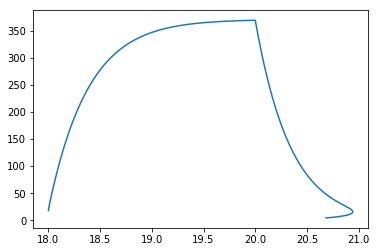

In [18]:
N = 10000 #15000
dt = 0.00001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 5.0 #1.2
delVmin = delV/3 #delV/3
delC= 0.01 #0.01
r_1= 70#*99/4#Max Firing rate is r_1 + r_0 70
r_0 = 5#*99/4 #Min firing rate 5
g_v = 5

params=zeros(15)
params[0]=N
params[1]=n #instead of actual n, cull neurons til desired value
params[2]=dt
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r_1
params[10]=V0
params[11]=C0
params[12]=delVmin #connenctivity rate from above.
params[13]=r_0 
params[14]=g_v

network = StepNetwork(M,l,params)

'''
print("initial edge count: {}".format(network.n_edges))
while True: 
    transition = False
    C,V,f,p_arr,v_arr,c_arr = network.simdyn(network.M,network.l,network.params)
    classification1 = classify(V,params) 
    k1 = largestkcore(network.M)
    network.killEdge() 
    C,V,f,p_arr,c_arr = network.simdyn(network.M,network.l,network.params)
    classification2 = classify(V,params)
    k2 = largestkcore(network.M)
    if k1 != k2: 
        print("kcore transition from k1 = {} to k2 = {}".format(k1,k2))
        transition = True
    if classification1 != classification2:
        if transition:
            print("Coincidence with kcore transition")
        print("Transition from {} to {} at n_edges = {}".format(classification1, classification2, network.n_edges))
        break

'''
C,V,c_arr,v_arr = network.simdyn(network.M,network.l,network.params)
plot(C,V)
#title("Mean Field, V > V* starting state")
#savefig("meeting_figs/mean_field_v_init.png")



In [274]:
count = 0
for i in c_arr[-1]:
    if i < Cstar:
        count += 1
        
count

48

In [1146]:
print(p_arr[0])
print(p_arr[-2])

[ 5. 75. 75.  5.  5. 75. 75. 75. 75. 75. 75.  5. 75.  5.  5. 75.  5. 75.
  5. 75.  5. 75.  5.  5. 75.  5.  5. 75.  5.  5.  5.  5.  5.  5. 75.  5.
  5. 75. 75.  5. 75.  5.  5. 75.  5.  5. 75.  5.  5.  5.  5. 75.  5. 75.
  5. 75. 75. 75. 75. 75. 75. 75.  5.  5.  5. 75. 75. 75. 75.  5. 75.  5.
 75. 75.  5.  5. 75. 75. 75.  5.  5.  5.  5.  5. 75. 75. 75.  5.  5. 75.
 75.  5.  5. 75.  5.  5.  5. 75.  5.  5.]
[ 5.  5.  5. 75.  5.  5. 75.  5.  5.  5. 75.  5. 75.  5.  5. 75. 75.  5.
  5. 75. 75.  5. 75. 75.  5.  5.  5. 75. 75. 75.  5. 75. 75.  5. 75.  5.
  5.  5. 75. 75. 75. 75. 75.  5.  5.  5.  5.  5. 75.  5. 75. 75.  5. 75.
  5. 75.  5. 75.  5.  5.  5.  5.  5. 75.  5. 75. 75.  5. 75. 75.  5. 75.
 75. 75. 75.  5.  5.  5.  5. 75. 75.  5. 75. 75. 75. 75.  5. 75.  5. 75.
 75.  5. 75. 75. 75. 75.  5. 75.  5. 75.]


In [1079]:
C,V,f,p_arr,v_arr,c_arr = network2.simdyn(network2.M,network2.l,network2.params)


In [1081]:
plot(C[:],V[:])
title(classify(V,network2.params))

Text(0.5, 1.0, '1')

In [1066]:
print(v_arr[-1])
print(v_arr[0])

[4.17992656e-43 2.50380425e-37 1.98000000e+02 1.98000000e+02
 1.98000000e+02]
[11.80080248 29.08734002 22.67705446  5.20969585  0.1939882 ]


In [1048]:
count = 1000000
plot(T[-count:],v_arr[-count:].T[0])
plot(T[-count:],v_arr[-count:].T[1])
plot(T[-count:],v_arr[-count:].T[2])
plot(T[-count:],v_arr[-count:].T[3])
plot(T[-count:],v_arr[-count:].T[4])
plot(T[-count:],v_arr[-count:].T[5])
plot(T[-count:],v_arr[-count:].T[6])
plot(T[-count:],v_arr[-count:].T[7])
plot(T[-count:],v_arr[-count:].T[8])
plot(T[-count:],v_arr[-count:].T[9])

In [950]:
network.killEdge()

True

In [1021]:
#C,V,f,p_arr,v_arr,c_arr = network.simdyn(network.M,network.l,network.params)
plot(C[:],V[:])
title(classify(V,network.params))

Text(0.5, 1.0, '3')

In [1026]:
v_arr[-1]

array([2.46539e-321, 4.95000e+001, 2.46539e-321, 2.46539e-321,
       2.46539e-321, 2.46539e-321, 2.46539e-321, 2.46539e-321,
       1.36125e+002, 2.46539e-321])

In [1027]:
count = 10000
plot(T[-count:],v_arr[-count:].T[0])
plot(T[-count:],v_arr[-count:].T[1])
plot(T[-count:],v_arr[-count:].T[2])
plot(T[-count:],v_arr[-count:].T[3])
plot(T[-count:],v_arr[-count:].T[4])

In [1029]:
network.M

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]])

In [1032]:
keep_M = network.M
keep_l = network.l

In [1084]:
C,V,f,p_arr,v_arr,c_arr = network.simdyn(keep_M, keep_l, network.params)

In [1085]:
plot(C,V)

In [1086]:
print(c_arr[-1])

[22.89375  4.95    22.89375 22.89375 22.89375 22.89375 22.89375 22.89375
 13.6125  22.89375]


In [1087]:
print(v_arr[-1])

[2.46539e-321 4.95000e+001 2.46539e-321 2.46539e-321 2.46539e-321
 2.46539e-321 2.46539e-321 2.46539e-321 1.36125e+002 2.46539e-321]


In [1089]:
print(f[-1])

[0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]


In [1041]:
count = 10000
plot(T[-count:],c_arr[-count:].T[0])
plot(T[-count:],c_arr[-count:].T[1])
plot(T[-count:],c_arr[-count:].T[2])
plot(T[-count:],c_arr[-count:].T[3])
plot(T[-count:],c_arr[-count:].T[4])
plot(T[-count:],c_arr[-count:].T[5])
plot(T[-count:],c_arr[-count:].T[6])
plot(T[-count:],c_arr[-count:].T[7])
plot(T[-count:],c_arr[-count:].T[8])
plot(T[-count:],c_arr[-count:].T[9])

### Compute probability of random configuration resulting in SO or F. 

In [68]:
n = 100
p = 1. #Probability of Connection 
M = getRandomConnectivity(n,p)
l = matrixOfEdges(M,n)

Text(0.5, 1.0, 'V: 2, C: 2')

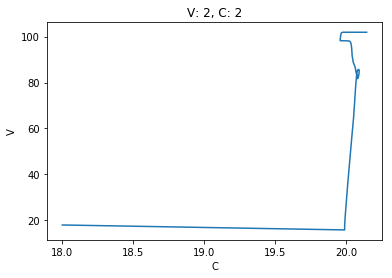

In [69]:
N = 10000 #15000
dt = 0.0001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 5.0 #1.2
delVmin = delV/3 #delV/3
delC= 0.01 #0.01
r_1 = 70 * 99/(n-1) #70*99/19#*99/4#Max Firing rate is r_1 + r_0 70
r_0 = 5 * 99/(n-1) #*99/4 #Min firing rate 5

params=zeros(14)
params[0]=N
params[1]=n #instead of actual n, cull neurons til desired value
params[2]=dt
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r_1
params[10]=V0
params[11]=C0
params[12]=delVmin #connenctivity rate from above.
params[13]=r_0 

N_samples = 100
V_init = []
V_final = []
C_init = []
C_final = []
v_classification = []
c_classification = []

network = StepNetwork(M,l,params)
'''
for i in range(N_samples):
    if i%10 == 0:
        print("Step {}".format(i))
    C,V,f,p_arr,v_arr,c_arr = network.simdyn(network.M,network.l,network.params)
    V_init.append(v_arr[0])
    V_final.append(v_arr[-1])
    C_init.append(c_arr[0])
    C_final.append(c_arr[-1])
    v_classification.append(classifier(V,1/dt,0.1))
    c_classification.append(classifier(C,1/dt,0.1))
'''
C,V,f,p_arr,v_arr,c_arr = network.simdyn(network.M,network.l,network.params)
plot(C[:],V[:])
xlabel("C")
ylabel("V")
title("V: {}, C: {}".format(classifier(V, 1/dt, 0.1), classifier(C, 1/dt, 0.1)))

In [1329]:
p_arr[0]

array([75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75.,
       75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75.,
       75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75.,
       75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75.,
       75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75.,
       75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75.,
       75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75., 75.,
       75., 75., 75., 75., 75., 75., 75., 75., 75.])

In [1351]:
c_arr[-2]

array([20.325     , 19.97499999, 19.97499999, 20.32500001, 20.32500002,
       20.32500001, 20.32500002, 19.97499998, 19.97499998, 19.97499998,
       19.97499998, 20.32500002, 19.97499999, 19.97499998, 20.32500001,
       20.32500001, 19.975     , 19.97499999, 19.97499999, 20.325     ,
       19.97499999, 20.325     , 20.325     , 19.97499999, 20.325     ,
       20.32500001, 20.32500001, 20.32500001, 20.32500001, 20.32500001,
       20.32500001, 19.97499999, 19.975     , 20.32500002, 19.97499998,
       19.97499998, 20.325     , 20.32500002, 19.975     , 19.97499999,
       19.97499998, 20.32500001, 20.32500002, 19.97499998, 20.32500001,
       19.97499999, 20.32500002, 19.97499999, 20.325     , 20.32500001,
       20.325     , 19.97499999, 20.32500001, 20.325     , 20.32500001,
       20.32500002, 20.32500002, 20.32500001, 20.325     , 19.97499999,
       20.325     , 20.325     , 19.97499999, 20.32500002, 19.97499998,
       19.97499999, 19.97499999, 19.975     , 20.325     , 19.97

In [1355]:
c_arr.shape

(100000, 100)

In [48]:
(n_firing ) * (r_1 + r_0) + (m_not_firing - 1) * r_0

3543.1578947368425

In [42]:
equality

3600.0

In [72]:
equality = Cstar/(tauc * delC)
n_firing = sum(f[-1] != 0)
m_not_firing = sum(f[-1] == 0)
print((((n_firing - 1) * (r_1 + r_0) + m_not_firing * r_0) < equality) and 
      ((n_firing * (r_1 + r_0) + (m_not_firing - 1) * r_0) > equality)) 
print("Firing: ", n_firing)
print("Quiescent: ", m_not_firing)

True
Firing:  51
Quiescent:  49


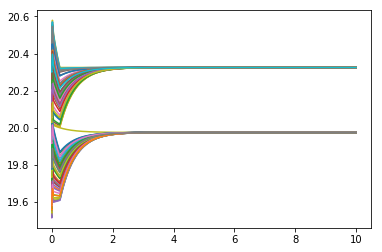

In [71]:
plot(T,c_arr)

### At what steepness parameter does the SO phase disappear? (using random initialization of neurons).

In [10]:
n = 100
p = 1. #Probability of Connection 
M = getRandomConnectivity(n,p)
l = matrixOfEdges(M,n)

In [13]:
N = 1000000 #15000
dt = 0.0001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv = 0.01 
tauc = 0.5
Vstar = 15
Cstar = 20 
V0 = np.random.uniform(Vstar-1,Vstar+1)#10 #20
C0 = np.random.uniform(Cstar-1,Cstar+1)#24 #24

delV = 3. #12
delC = 0.015
r = 70
r_0 = 5

g = 0.5
g_v = g #.95
g_c = g #.95

params = zeros(15)
params[0] = N
params[1] = n
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

N_samples = 100
V_final=[]
C_final=[]
g_arr = []
v_classification = []
c_classification = []

network = MeanFieldStepNetwork(M,l,params)

dg = 0.05

N_samples = 10
for i in range(N_samples):
    print(i)
    V0 = np.random.uniform(Vstar-1,Vstar+1)
    C0 = np.random.uniform(Cstar-1,Cstar+1)
    
    params[10] = V0
    params[11] = C0
    
    g = 4
    
    params[12] = g
    params[13] = g
    
    network=MeanFieldStepNetwork(M,l,params)
    
    while(g > 0):
        Ca,Va,Ci,Vi = network.simdyn(network.params)
        v_class = classifier(Va,1/dt,0.1)
        c_class = classifier(Ca,1/dt,0.1)
        if v_class != 1 or c_class !=1:
            v_classification.append(v_class)
            c_classification.append(c_class)
            C_final.append(Ca)
            V_final.append(Va)
            g_arr.append(g)
            break
        g -= dg
        params[12] = g
        params[13] = g
        network=MeanFieldStepNetwork(M,l,params)

'''
for i in range(N_samples):
    if i%10 == 0:
        print("Step {}".format(i))
    C,V,f,p_arr,v_arr,c_arr = network.simdyn(network.M,network.l,network.params)
    V_init.append(v_arr[0])
    V_final.append(v_arr[-1])
    C_init.append(c_arr[0])
    C_final.append(c_arr[-1])
    v_classification.append(classifier(V,1/dt,0.1))
    c_classification.append(classifier(C,1/dt,0.1))
'''

#C,V = network.simdyn(network.M,network.l,network.params)
#plot(C[:],V[:])
#xlabel("C")
#ylabel("V")
#title("V: {}, C: {}".format(classifier(V, 1/dt, 0.1), classifier(C, 1/dt, 0.1)))

0
1
2
3
4
5
6
7
8
9


'\nfor i in range(N_samples):\n    if i%10 == 0:\n        print("Step {}".format(i))\n    C,V,f,p_arr,v_arr,c_arr = network.simdyn(network.M,network.l,network.params)\n    V_init.append(v_arr[0])\n    V_final.append(v_arr[-1])\n    C_init.append(c_arr[0])\n    C_final.append(c_arr[-1])\n    v_classification.append(classifier(V,1/dt,0.1))\n    c_classification.append(classifier(C,1/dt,0.1))\n'

In [14]:
g_arr

[2.300000000000006,
 2.300000000000006,
 2.300000000000006,
 2.300000000000006,
 2.300000000000006,
 2.300000000000006,
 2.300000000000006,
 2.300000000000006,
 2.300000000000006,
 2.300000000000006]

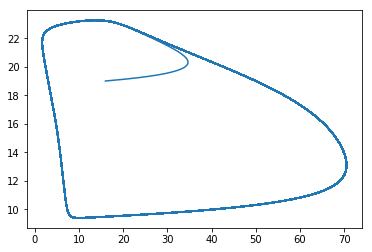

In [17]:
network=MeanFieldStepNetwork(M,l,params)
g = 2.35
params[12]=g
params[13]=g
Ca,Va,Ci,Vi = network.simdyn(network.params)
plot(Ca,Va)

In [165]:
sum(v_arr[-1])/56.723


32.00016683906536

In [164]:
v_arr[-1]

array([5.67233097e+01, 1.03707409e-14, 5.67233097e+01, 1.03707403e-14,
       5.67233094e+01, 1.03707404e-14, 1.03707398e-14, 5.67233100e+01,
       1.03707386e-14, 1.03707395e-14, 1.03707405e-14, 1.03707384e-14,
       1.03707395e-14, 1.03707392e-14, 1.03707401e-14, 1.03707404e-14,
       5.67233106e+01, 1.03707390e-14, 1.03707393e-14, 1.03707399e-14,
       1.03707405e-14, 5.67233096e+01, 1.03707385e-14, 5.67233105e+01,
       1.03707406e-14, 5.67233086e+01, 1.03707391e-14, 1.03707399e-14,
       5.67233106e+01, 1.03707389e-14, 1.03707404e-14, 1.03707396e-14,
       1.03707404e-14, 5.67233107e+01, 5.67233105e+01, 1.03707402e-14,
       1.03707385e-14, 1.03707393e-14, 5.67233107e+01, 1.03707399e-14,
       1.03707385e-14, 1.03707401e-14, 5.67233092e+01, 1.03707389e-14,
       1.03707398e-14, 5.67233105e+01, 1.03707395e-14, 1.03707402e-14,
       1.03707397e-14, 1.03707401e-14, 1.03707395e-14, 1.03707393e-14,
       1.03707403e-14, 5.67233105e+01, 1.03707396e-14, 1.03707399e-14,
      

### phase diagram: number of neurons vs g

In [185]:
n = 100
p = 1. #Probability of Connection 
M = getRandomConnectivity(n,p)
l = matrixOfEdges(M,n)

phasen13 = []
phaseg13 = []

phasen12 = []
phaseg12 = []

phasen32 = []
phaseg32 = []

In [245]:
phasen12 = []
phaseg12 = []

N = 10000 #15000
dt = 0.001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv = 0.01 
tauc = 0.5
Vstar = 15
Cstar = 20 
V0 = 10 #20
C0 = 24 #24

delV = 5. #12
delC = 0.015
r = 70
r_0 = 5

g = 0.1
g_v = g #.95
g_c = g #.95

params = zeros(15)
params[0] = N
params[1] = n
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M,l,params)
network.init_kill_order()

g_max = 5.
dg = 0.1
edge_min = network.n_edges//4
edge_step = 20

while True: 
    C,V,c_arr,v_arr = network.simdyn(network.M,network.l,network.params)
    classification1 = classify(V,network.params)
    n_culled = 0
    while True: 
        if n_culled >= n-1:
            network.params[12] += dg
            network.params[13] += dg
            network.M = network.M_init
            network.l = network.l_init
            network.n = network.n_init
            break
            
        else:
            network.kill_neuron()
            n_culled += 1
            
        C,V,c_arr,v_arr = network.simdyn(network.M,network.l,network.params)
        classification2 = classify(V,network.params)
        if classification2 != classification1: 
            #if classification2 == 3 and classification1 == 1:
            #    phasen13.append(network.n)
            #    phaseg13.append(network.params[12])
                
            if classification2 == 2 and classification1 == 1:
                phasen12.append(network.n)
                phaseg12.append(network.params[12])
            
                print("Transition at n = {}, g = {}, from {} to {}".format(network.n,network.params[12],
                                                                              classification1,classification2))
                network.params[12] += dg 
                network.params[13] += dg 
                network.M = network.M_init
                network.l = network.l_init 
                network.n = network.n_init
                break
                
            #elif classification2 == 2 and classification1 == 3:
            #    phasen32.append(network.n)
            #    phaseg32.append(network.params[12])

            
        
            
    if network.params[12] >= g_max:
        break

Transition at n = 57, g = 0.1, from 1 to 2
Transition at n = 41, g = 0.7999999999999999, from 1 to 2
Transition at n = 32, g = 1.3, from 1 to 2
Transition at n = 28, g = 1.6000000000000003, from 1 to 2
Transition at n = 24, g = 1.9000000000000006, from 1 to 2
Transition at n = 20, g = 2.3000000000000007, from 1 to 2
Transition at n = 15, g = 3.0000000000000013, from 1 to 2
Transition at n = 15, g = 3.1000000000000014, from 1 to 2
Transition at n = 13, g = 3.4000000000000017, from 1 to 2
Transition at n = 13, g = 3.5000000000000018, from 1 to 2
Transition at n = 12, g = 3.600000000000002, from 1 to 2
Transition at n = 12, g = 3.700000000000002, from 1 to 2
Transition at n = 12, g = 3.800000000000002, from 1 to 2
Transition at n = 11, g = 3.900000000000002, from 1 to 2
Transition at n = 10, g = 4.4, from 1 to 2
Transition at n = 10, g = 4.6, from 1 to 2


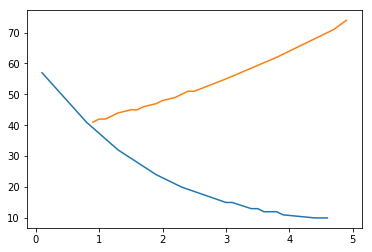

In [247]:
plot(phaseg12, phasen12)
plot(phaseg13, phasen13)
#savefig("meeting_figs/phase.png")

In [250]:
N = 10000 #15000
dt = 0.001
T = zeros(N)
for i in range(N):
    T[i] = i*dt

tauv = 0.01 
tauc = 0.5
Vstar = 15
Cstar = 20 
V0 = 10 #20
C0 = 24 #24

target_n = 55

delV = 5. #12
delC = 0.015
r = 70
r_0 = 5

g = 3.
g_v = g #.95
g_c = g #.95

params = zeros(15)
params[0] = N
params[1] = n
params[2] = dt
params[3] = tauv
params[4] = tauc
params[5] = Vstar
params[6] = Cstar
params[7] = delV
params[8] = delC
params[9] = r
params[10] = V0
params[11] = C0
params[12] = g_v
params[13] = g_c
params[14] = r_0

network = Network(M,l,params)

for i in range(n-target_n):
    network.kill_neuron()
    
C,V,c_arr,v_arr = network.simdyn(network.M,network.l,network.params)

3
55


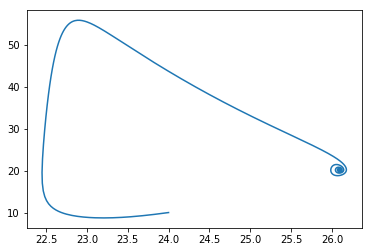

In [256]:
plot(C,V)
print(classify(V,network.params))
print(network.n)


In [258]:
firing_count = 0
for i in range(len(v_arr[-1])):
    if v_arr[-1,i] > Vstar: #and c_arr[-1,i] < Cstar:
        firing_count += 1
        
print(firing_count)

55


In [259]:
v_arr[-1]

array([20.1789518, 20.1789518, 20.1789518, 20.1789518, 20.1789518,
       20.1789518, 20.1789518, 20.1789518, 20.1789518, 20.1789518,
       20.1789518, 20.1789518, 20.1789518, 20.1789518, 20.1789518,
       20.1789518, 20.1789518, 20.1789518, 20.1789518, 20.1789518,
       20.1789518, 20.1789518, 20.1789518, 20.1789518, 20.1789518,
       20.1789518, 20.1789518, 20.1789518, 20.1789518, 20.1789518,
       20.1789518, 20.1789518, 20.1789518, 20.1789518, 20.1789518,
       20.1789518, 20.1789518, 20.1789518, 20.1789518, 20.1789518,
       20.1789518, 20.1789518, 20.1789518, 20.1789518, 20.1789518,
       20.1789518, 20.1789518, 20.1789518, 20.1789518, 20.1789518,
       20.1789518, 20.1789518, 20.1789518, 20.1789518, 20.1789518])

### Mean Field Comparison to Schwab Paper

In [14]:
p = 1#1/6
n=100 #100
M=getRandomConnectivity(n,p) #args(n,p)
l=matrixOfEdges(M,n)

In [ ]:
N=10000
dt=0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt


M_prime = copy.deepcopy(M)
l_prime = copy.deepcopy(l)
#curr_n = n #Current number of neurons in network 
to_cull = 0

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #Constant (according to experiments) 15
Cstar=5 #15
V0=18 #18
C0=3 #18

delV= 1. #1.2
delC= 0.025 #0.015
r= 75 #70
rb = 5
gc = 3
gv = 5

params=zeros(15)
params[0]=N
params[1]=n
params[2]=dt
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r
params[10]=V0
params[11]=C0
params[12] = rb
params[13] = gc
params[14] = gv

dV = 0.1
delVmax = 15.

V_space = np.arange(delV, delVmax, dV)
n_space = np.arange(2,n+1)

phase = np.zeros((len(n_space), len(V_space)))

network = 